<h1>Importing essential libraries</h1>

In [1]:
import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip  install imblearn
!{sys.executable} -m pip  install catboost

In [18]:
# Importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt

# Importing various models and tools 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<h1>Importing Dataset</h1>

We import the dataset that has been cleaned and does not contain any duplicates.

In [19]:
wine_data = pd.read_csv("binned_no_dup.csv")

wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0


## Outlier removal
We can remove the outliers for each predictor variable in our dataset, so that our trained models will not be impacted by the outliers. We do this by removing data points with predictor variable values beyond 1.5 * IQR of the first or third quartile.

In [20]:
# Cleaning dataset: Removing outliers
wine_predictors = wine_data.drop('quality', axis = 1)
wine_quality = wine_data['quality']


Q1_joint = wine_predictors.quantile(0.25)
Q3_joint = wine_predictors.quantile(0.75)
IQR_joint = Q3_joint - Q1_joint
idx_joint_cleaned = ~((wine_predictors < (Q1_joint - 1.5 * IQR_joint)) | (wine_predictors > (Q3_joint + 1.5 * IQR_joint))).any(axis=1)

wine_predictors_cleaned = wine_predictors.loc[idx_joint_cleaned]

wine_data_cleaned = wine_predictors_cleaned.join(wine_quality)

wine_data_cleaned.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,8.169872,0.522507,0.250805,2.198822,0.078452,14.959764,42.388616,0.996547,3.322385,0.631237,10.385967,0.538763
std,1.475073,0.167364,0.182313,0.452214,0.014973,8.838951,26.625802,0.001616,0.132589,0.114861,0.992372,0.498740
min,5.100000,0.120000,0.000000,1.200000,0.039000,1.000000,6.000000,0.992350,2.940000,0.330000,8.700000,0.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995500,3.230000,0.550000,9.500000,0.000000
50%,7.800000,0.520000,0.240000,2.100000,0.078000,13.000000,36.000000,0.996560,3.320000,0.610000,10.100000,1.000000
75%,9.000000,0.630000,0.400000,2.500000,0.087000,20.000000,56.000000,0.997600,3.400000,0.700000,11.000000,1.000000
max,12.300000,1.010000,0.730000,3.650000,0.122000,42.000000,124.000000,1.001000,3.680000,0.980000,13.400000,1.000000


([<matplotlib.axis.XTick at 0x1aaa7f44430>,
 <a list of 2 Text major ticklabel objects>)

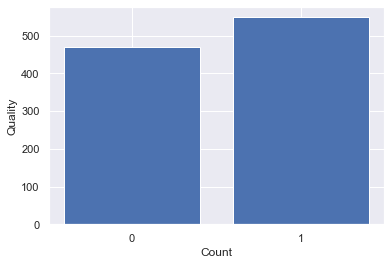

In [21]:
plt.bar(x = wine_data_cleaned['quality'].value_counts().index.tolist(),
       height = wine_data_cleaned['quality'].value_counts())
plt.xlabel('Count')
plt.ylabel('Quality')
plt.xticks([0,1])

As in `2.3 Modelling with Feature Selection`, the median, min, max, 1st quartile, and 3rd quartile values for pH and residual sugar, do not vary significantly for qualities good and bad. This suggests there is no strong relationship between these 2 variables and the quality of the wine.

Hence, we decide to drop these columns.

In [22]:
wine_data_dropped = wine_data_cleaned.drop(columns=['pH', 'residual sugar'])

wine_data_dropped

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.700,0.00,0.076,11.0,34.0,0.99780,0.56,9.4,0
1,7.8,0.880,0.00,0.098,25.0,67.0,0.99680,0.68,9.8,0
2,7.8,0.760,0.04,0.092,15.0,54.0,0.99700,0.65,9.8,0
3,11.2,0.280,0.56,0.075,17.0,60.0,0.99800,0.58,9.8,1
4,7.4,0.660,0.00,0.075,13.0,40.0,0.99780,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,0.068,28.0,38.0,0.99651,0.82,9.5,1
1355,6.2,0.600,0.08,0.090,32.0,44.0,0.99490,0.58,10.5,0
1356,5.9,0.550,0.10,0.062,39.0,51.0,0.99512,0.76,11.2,1
1357,5.9,0.645,0.12,0.075,32.0,44.0,0.99547,0.71,10.2,0


<h1>Machine Learning</h1>

We split the dataset into the predictors (X) and the response variable 'quality' (y).

In [23]:
target_label = 'quality'
X = wine_data_dropped.drop([target_label], axis=1)
y = wine_data_dropped[target_label]

([<matplotlib.axis.XTick at 0x1aaa90f4b20>,
 <a list of 2 Text major ticklabel objects>)

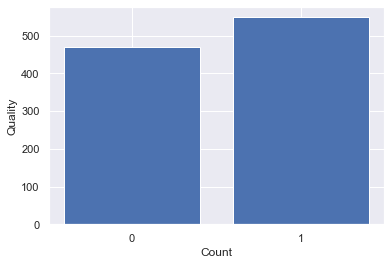

In [24]:
plt.bar(x = y.value_counts().index.tolist(),
       height = y.value_counts())
plt.xlabel('Count')
plt.ylabel('Quality')
plt.xticks([0,1])

<h2> Train Test Split </h2>

We use the train_test_split() function to split the dataset into the train set, and the test set, with a test size of 0.2.
We also specify stratify = y. This is to ensure that the ratio of good:bad values are consistent throughout the train set and the test set.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)

<h2>Model Fitting & Hyperparameter Tuning</h2>

For each of the models used below, the GridSearchCV function is used to determine the optimal hyperparameters for each model (i.e. the hyperparameters which result in the highest accuracy scores on the trainset). 5-fold cross validation is used to obtain unbiased results as well as to determine the optimal hyperparameters of each model.

In [10]:
# Importing libraries used for model fitting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

<H2> (1) Logistic Regression </H2>

Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. Logistic regression is a useful analysis method for classification problems, where you are trying to determine if a new sample fits best into a category. 
It is a simple and more efficient method for binary and linear classification problems. It performs relatively well in our dataset as our response variables are binary. 


In [11]:
param_grid = {'penalty':['l1', 'l2', 'elasticnet'],
              'C': np.logspace(-3, 3, 7),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'random_state': [42]}

grid_search_logreg = GridSearchCV(LogisticRegression(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=1)
grid_search_logreg.fit(X_train,y_train)
print("Best parameters: ", grid_search_logreg.best_params_)
print("Best CV score: ", grid_search_logreg.best_score_)

best_logreg = LogisticRegression(**grid_search_logreg.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_logreg.score(X_test, y_test))

Best parameters:  {'C': 1.0, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
Best CV score:  0.7374233128834355
Test accuracy:  0.7401960784313726


<h2> (2) Gaussian Naive Bayes </h2>

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. 

For our dataset, we chose to use Gaussian Naive Bayes where the likelihood of each predictor is assumed to be Gaussian (normal distribution).

In [12]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100),}

grid_search_gnb = GridSearchCV(GaussianNB(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)
grid_search_gnb.fit(X_train,y_train)
print("Best parameters: ", grid_search_gnb.best_params_)
print("Best CV score: ", grid_search_gnb.best_score_)

best_gnb = GaussianNB(**grid_search_gnb.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_gnb.score(X_test, y_test))

Best parameters:  {'var_smoothing': 2.310129700083158e-09}
Best CV score:  0.7276073619631902
Test accuracy:  0.7598039215686274


<h2> (3) Decision Tree Classifier </h2>

The Decision Tree Classifier belongs to the family of supervised learning algorithms. The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class. The Decision Tree classifier can handle both categorical and numerical data (numerical data as predictors in this dataset), and is simple to understand and interpret since the trees can be visualised.

In [13]:
param_grid = {'max_depth':[None, [i for i in range(1,50,1)]],
             'random_state': [42]}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_dtc.fit(X_train,y_train)
print("Best parameters: ", grid_search_dtc.best_params_)
print("Best CV score: ", grid_search_dtc.best_score_)

best_dtc = DecisionTreeClassifier(**grid_search_dtc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_dtc.score(X_test, y_test))

Best parameters:  {'max_depth': None, 'random_state': 42}
Best CV score:  0.6871165644171779
Test accuracy:  0.6568627450980392


<h2> (4) Random Forest Classifier </h2>

The Random Forest Classifier builds multiple decision trees and merges them together to get a more accurate and stable prediction. One big advantage of random forest is that it can be used for both classification and regression problems, and is suitable for binary classification of wines in this dataset.  Random forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in an improved model.

In [14]:
param_grid = {'max_depth':[i for i in range(1,30,3)],
             'n_estimators': [j for j in range(10, 601, 40)],
             'random_state': [42]}


grid_search_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_rfc.fit(X_train,y_train)
print("Best parameters: ", grid_search_rfc.best_params_)
print("Best CV score: ", grid_search_rfc.best_score_)

best_rfc = RandomForestClassifier(**grid_search_rfc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_rfc.score(X_test, y_test))

Best parameters:  {'max_depth': 13, 'n_estimators': 50, 'random_state': 42}
Best CV score:  0.747239263803681
Test accuracy:  0.7401960784313726


<h2> (5) AdaBoost Classifier </h2>

AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get a high accuracy strong classifier. The method automatically adjusts its parameters to the data based on the actual performance in the current iteration, meaning, both the weights for re-weighting the data and the weights for the final aggregation are re-computed iteratively.


In [15]:
param_grid = {'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
             'n_estimators': [j for j in range(10, 601, 40)],
             'random_state': [42]}

grid_search_abc = GridSearchCV(AdaBoostClassifier(), param_grid, cv= KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_abc.fit(X_train,y_train)
print("Best parameters: ", grid_search_abc.best_params_)
print("Best CV score: ", grid_search_abc.best_score_)

best_abc = AdaBoostClassifier(**grid_search_abc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_abc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.1, 'n_estimators': 210, 'random_state': 42}
Best CV score:  0.7435582822085889
Test accuracy:  0.7254901960784313


<h2> (6) CatBoost Classifier </h2>

The CatBoost Classifier is a high-performance open source library for gradient boosting on decision trees. In the growing procedure of the decision trees, CatBoost does not follow similar gradient boosting models. Instead, CatBoost grows oblivious trees, which means that the trees are grown by imposing the rule that all nodes at the same level, test the same predictor with the same condition, and hence an index of a leaf can be calculated with bitwise operations.

In [16]:
from catboost import CatBoostClassifier

param_grid = {'learning_rate': [0.08, 0.1, 0.15, 0.2, 0.25, 0.3], 
             'n_estimators': [200, 250, 300, 350, 400, 450, 500],
             'random_state': [42]}


grid_search_cbc = GridSearchCV(CatBoostClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_cbc.fit(X_train, y_train, silent=True)
print("Best parameters: ", grid_search_cbc.best_params_)
print("Best CV score: ", grid_search_cbc.best_score_)

best_cbc = CatBoostClassifier(**grid_search_cbc.best_params_).fit(X_train, y_train, silent=True)
print("Test accuracy: ", best_cbc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.2, 'n_estimators': 450, 'random_state': 42}
Best CV score:  0.7374233128834357
Test accuracy:  0.7450980392156863


<h2> (7) GradientBoost Classifier </h2>

Gradient Boosting Classifiers are the AdaBoosting method combined with weighted minimization, after which the classifiers and weighted inputs are recalculated. The objective of Gradient Boosting Classifiers is to minimize the loss, or the difference between the actual class value of the training example and the predicted class value.

In [17]:
param_grid = {'learning_rate':[0.008, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24], 
             'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500, 550, 600],
             'random_state': [42]}

grid_search_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=KFold(5, shuffle=True, random_state=42), n_jobs=-1)

grid_search_gbc.fit(X_train,y_train)
print("Best parameters: ", grid_search_gbc.best_params_)
print("Best CV score: ", grid_search_gbc.best_score_)

best_gbc = GradientBoostingClassifier(**grid_search_gbc.best_params_).fit(X_train, y_train)
print("Test accuracy: ", best_gbc.score(X_test, y_test))

Best parameters:  {'learning_rate': 0.008, 'n_estimators': 500, 'random_state': 42}
Best CV score:  0.7361963190184049
Test accuracy:  0.7450980392156863


<h2> Conclusion </h2>

Using the dataset with no duplicates, with no outliers, and with feature selection (columns removed), we note that the Naive Bayes Classifier performs the best with a classification accuracy of 75.98%.